### DATASET: Primary school temporal network data

This data set contains the temporal network of contacts between the children and teachers used in the study published in BMC Infectious Diseases 2014, 14:695. The file contains a tab-separated list representing the active contacts during 20-second intervals of the data collection. Each line has the form “t i j Ci Cj”, where i and j are the anonymous IDs of the persons in contact, Ci and Cj are their classes, and the interval during which this contact was active is [ t – 20s, t ]. If multiple contacts are active in a given interval, you will see multiple lines starting with the same value of t. Time is measured in seconds.

In [1]:
import numpy             as np
import brainconn         as bc
import pandas            as pd
import xarray            as xr
import numba             as nb
import matplotlib.pyplot as plt

import ctypes

from   tqdm              import tqdm
from   net.layerwise     import *

#### Define methods to load data

In [2]:
_DATA_PATH      = 'data-sets/primaryschool/primaryschool.csv'
_META_DATA_PATH = 'data-sets/primaryschool/metadata_primaryschool.txt'

In [3]:
def _load_data_as_adj(data_path, meta_data_path, verbose=False):
    # Loading data and metadata
    data     = pd.read_csv(data_path, header=None, delimiter='\t', usecols=[0,1,2], names=['t','i','j','Ci','Cj'])
    metadata = np.loadtxt(meta_data_path, usecols=(0,1), dtype=str)
    # Mapping nodes labels to indexes
    idx      = np.arange(metadata.shape[0], dtype=int)
    # Numerical labels to index
    n_labels = dict( zip(metadata[:,0].astype(int),idx) )
    # Literal labels to index
    s_labels = metadata[:,1]
    # Replacing nodes labes
    data['i'] = data['i'].map(n_labels)
    data['j'] = data['j'].map(n_labels)
    # Get sources and targets
    x_s   = data.groupby('t')['i'].apply(list)
    x_t   = data.groupby('t')['j'].apply(list)
    #times = x_s.index.values 
    # Convert to array
    x_s   = x_s.values
    x_t   = x_t.values
    # Get number of nodes and time-points
    n_nodes  = len(metadata[:,0])
    n_times  = len(x_s)
    times    = np.arange(n_times, dtype=int)
    # Adjacency tensor
    A   = np.zeros((n_nodes,n_nodes,n_times))
    itr = range(len(times))
    for t in tqdm(itr) if verbose else itr:
        A[x_s[t],x_t[t],t] = A[x_t[t],x_s[t],t] = 1
        np.fill_diagonal(A[...,t],1)
    # Convert to x-array
    A = xr.DataArray( A[:,:,None,:], dims=("sources", "targets", "trials", "times"),
                         coords={"sources":s_labels, 
                                 "targets":s_labels, 
                                 "times":times}
                    )
    return A

#### Load data as adjacency tensor

In [4]:
A = _load_data_as_adj(_DATA_PATH, _META_DATA_PATH, verbose=True)

100%|██████████| 3100/3100 [00:00<00:00, 28229.51it/s]


In [5]:
# Saving snapshots of the adjacency tensor
#for t in tqdm( range(A.sizes['times']) ):
#    plt.figure(figsize=(12,10) )
#    plt.imshow(A[...,t], aspect='auto', cmap='gray', origlayerwiseower')
#    plt.savefig(f'figures/{t}.png')
#    plt.close()

### Degree and Modularity time-series

In [6]:
# Computing degree time-series
d=compute_nodes_degree(A)
# Computing modularity time-series
## Igraph
m_ig=compute_network_modularity(A, verbose=True, backend='igraph', n_jobs=1)
# Brainconn
m_bc=compute_network_modularity(A, verbose=True, backend='brainconn', n_jobs=-1)

Finding network partitions.



100%|██████████| 3100/3100 [00:05<00:00, 521.01it/s]


  0%|          |  : 0/3100 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3100 out of 3100 | elapsed:  3.5min finished


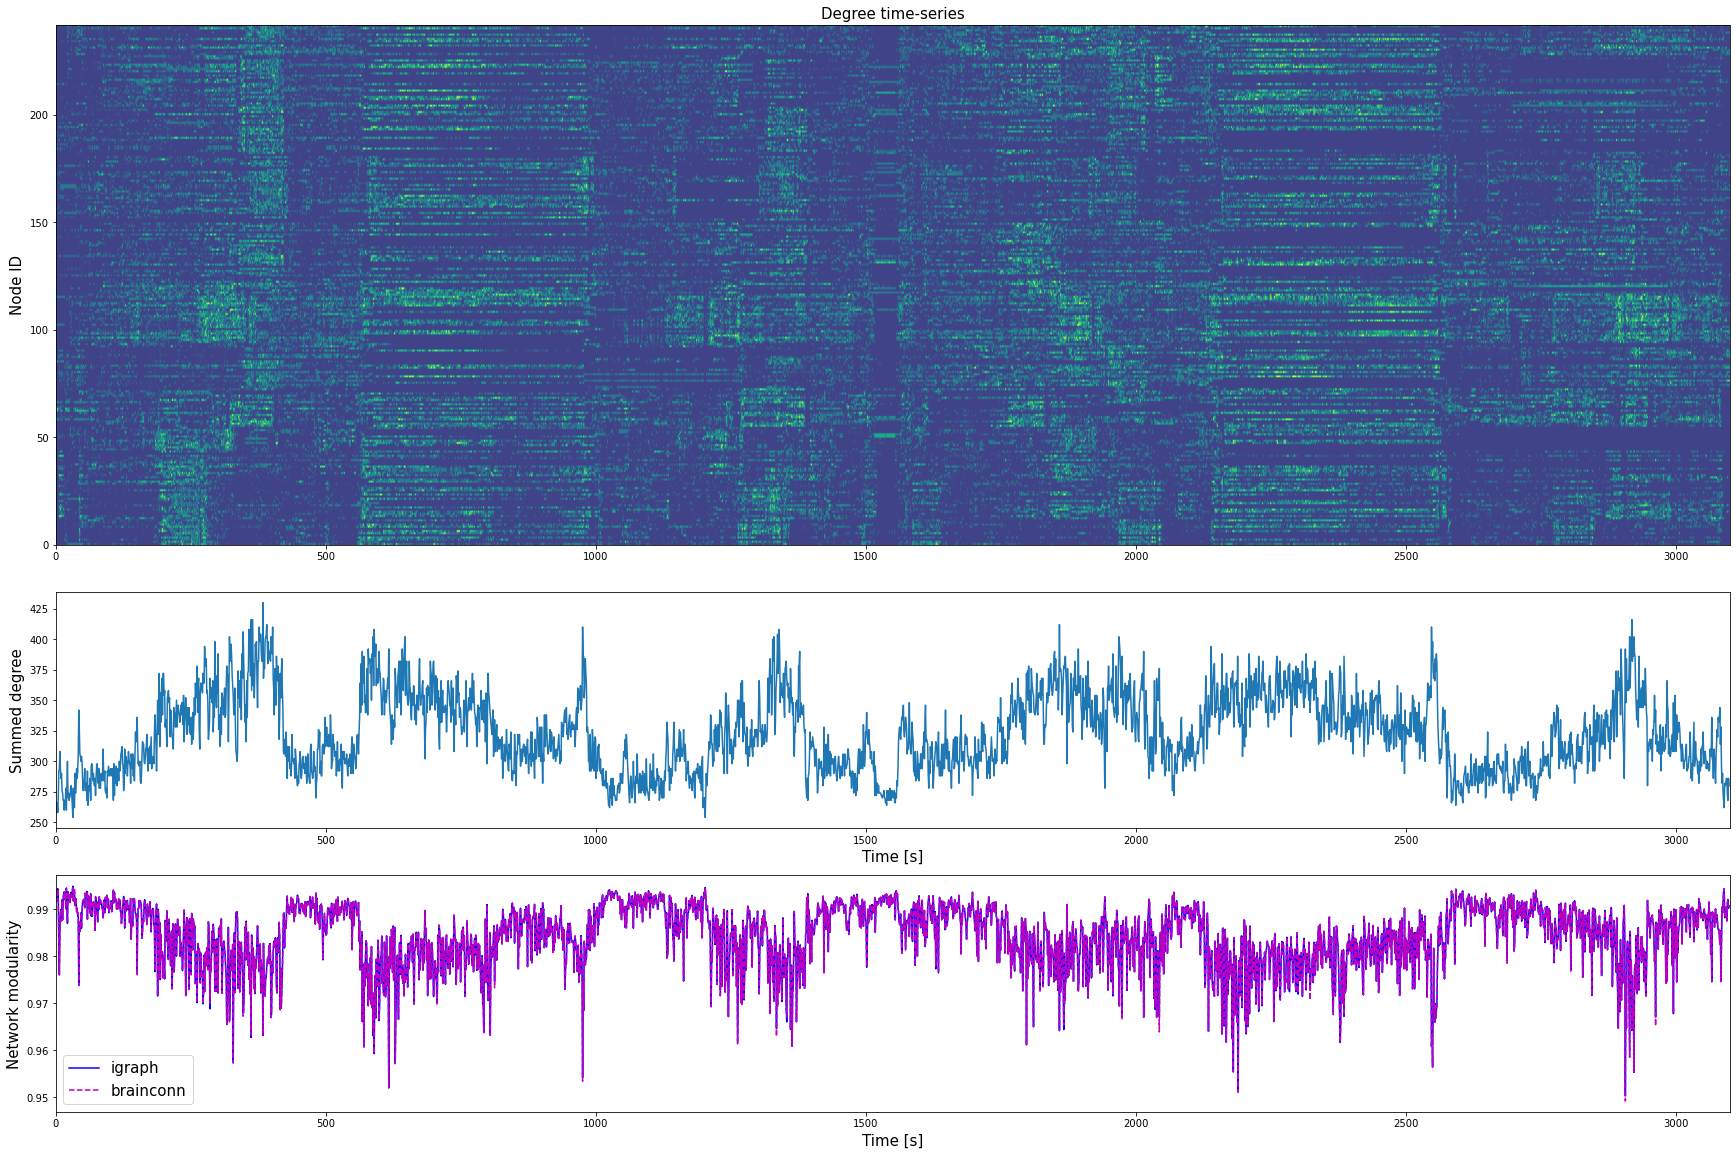

In [7]:
plt.figure(figsize=(30,20))
plt.subplot2grid((4,3),(0,0),rowspan=2,colspan=3)
plt.imshow( d.isel(trials=0), aspect='auto', cmap='viridis', origin='lower', extent=[0, A.sizes['times'], 0, A.sizes['sources']], vmin=0, vmax=5)
plt.ylabel('Node ID', fontsize=15)
#plt.yticks(range(A.sizes['sources']),A.sources.values)
plt.title('Degree time-series', fontsize=15)
plt.subplot2grid((4,3),(2,0),rowspan=1,colspan=3)
plt.plot(d.isel(trials=0).sum(dim='roi').values )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Summed degree', fontsize=15)
plt.subplot2grid((4,3),(3,0),rowspan=1,colspan=3)
plt.plot( m_ig.isel(trials=0), 'b'  , label='igraph')
plt.plot( m_bc.isel(trials=0), 'm--', label='brainconn' )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Network modularity', fontsize=15)
plt.legend(fontsize=15);

### Network partitions

In [8]:
# Estimating partitions using igraph
p_ig = compute_network_partition(A, verbose=False, backend='igraph', n_jobs=-1)

In [9]:
# Estimating partitions using brainconn
p_bc = compute_network_partition(A, verbose=False, backend='brainconn', n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Affiliation vector - Brainconn')

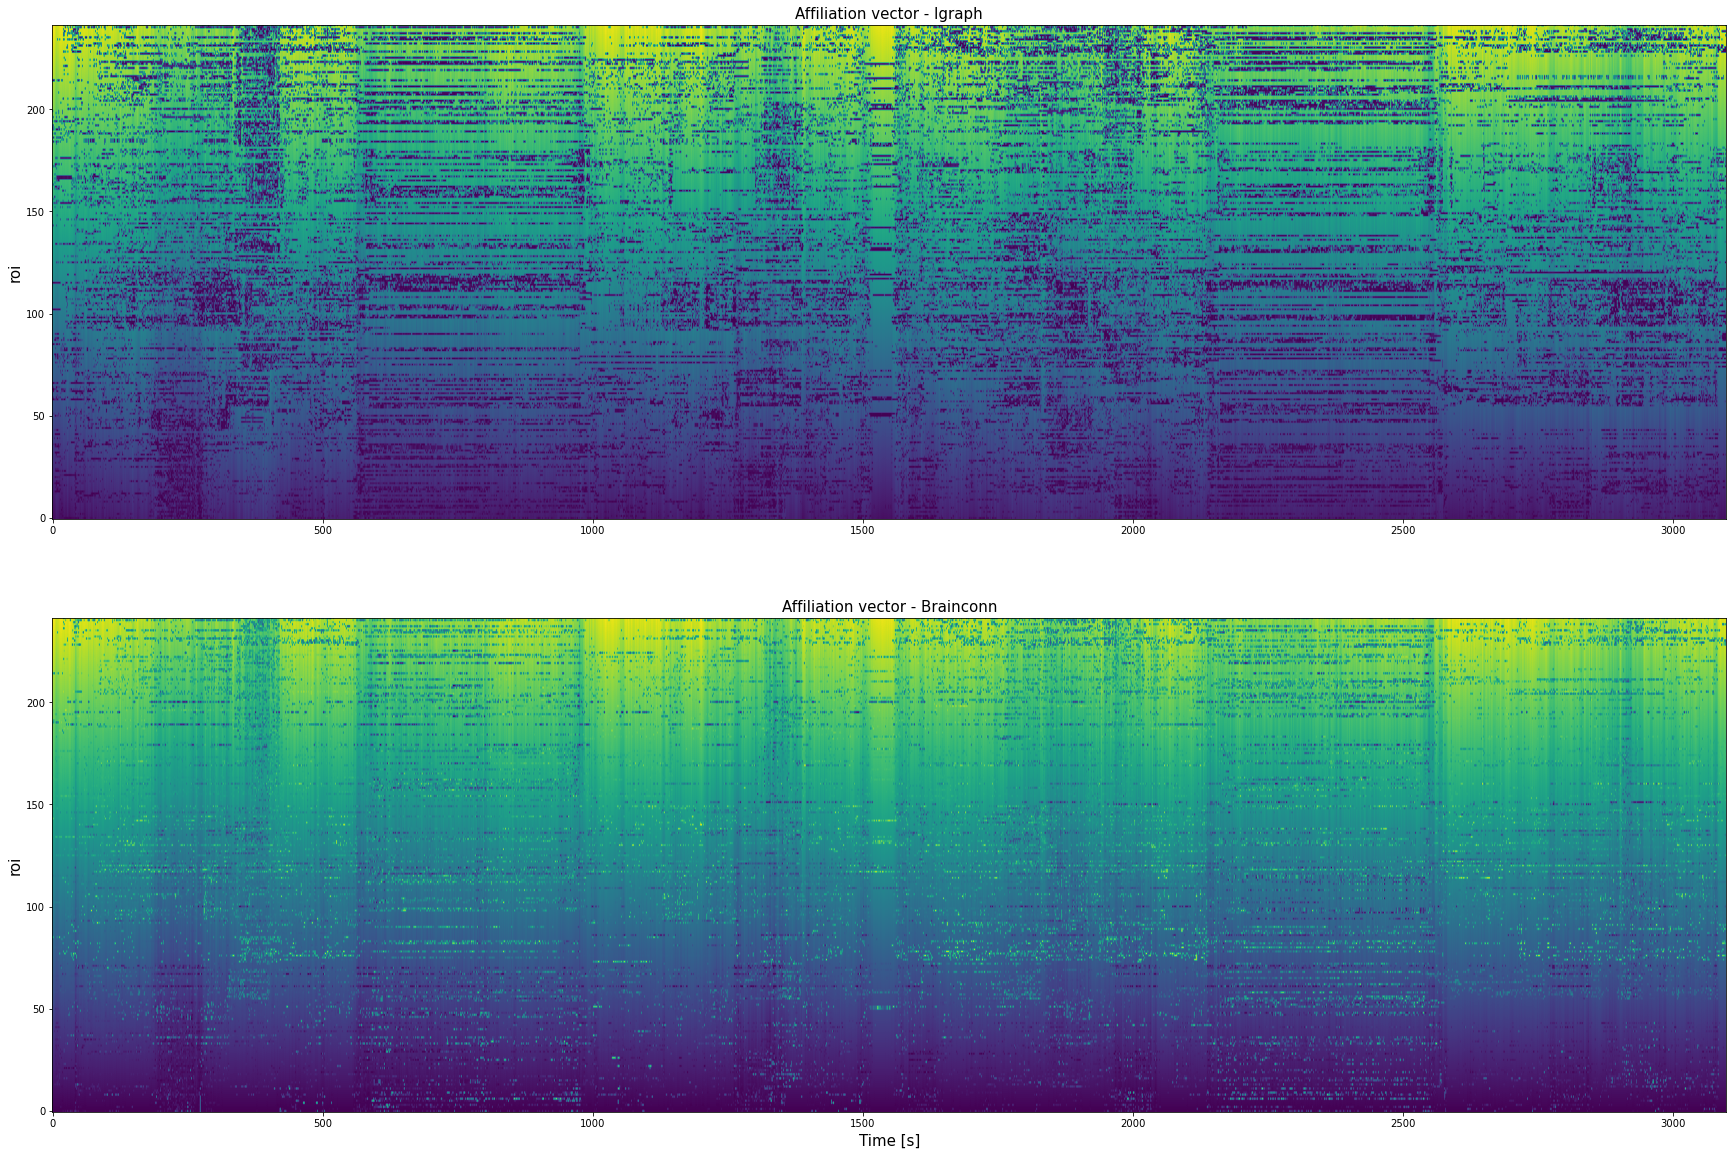

In [10]:
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(p_ig.isel(trials=0), aspect='auto', cmap='viridis', origin='lower')
plt.ylabel('roi', fontsize=15)
plt.title('Affiliation vector - Igraph', fontsize=15)
plt.subplot(2,1,2)
plt.imshow(p_bc.isel(trials=0), aspect='auto', cmap='viridis', origin='lower')
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('roi', fontsize=15)
plt.title('Affiliation vector - Brainconn', fontsize=15)

#### Nodes' allegiance matrix

In [11]:
T_ig = compute_allegiance_matrix(A, verbose=False, backend='igraph', n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [12]:
T_bc = compute_allegiance_matrix(A, verbose=False, backend='brainconn', n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

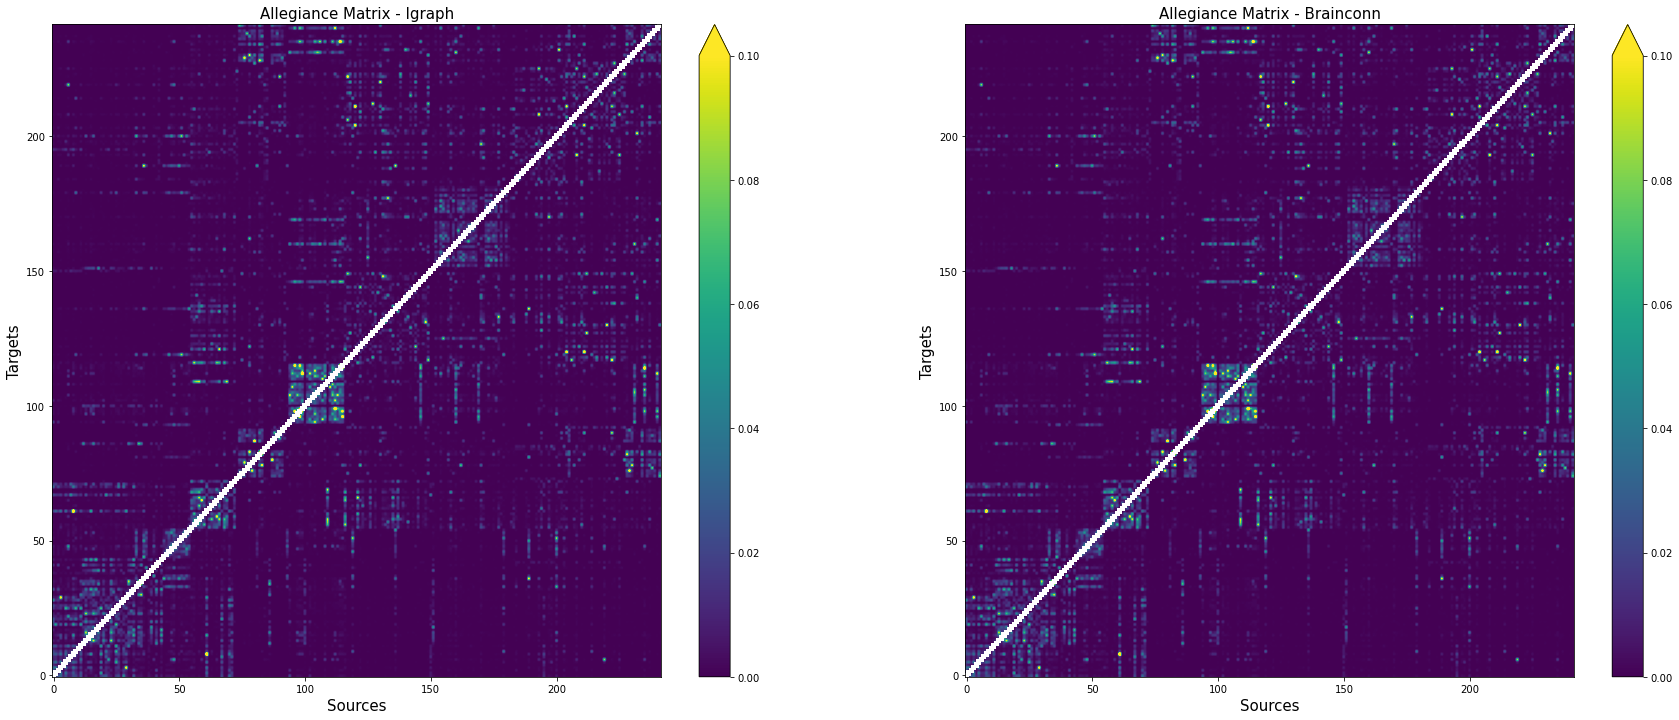

In [13]:
plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
np.fill_diagonal(T_ig.values,np.nan)
plt.imshow(T_ig, aspect="auto",cmap="viridis",origin="lower", vmin=0, vmax=0.1)
#plt.xticks(range(T_ig.sizes['sources']),T_ig.sources.values, rotation=270)
#plt.yticks(range(T_ig.sizes['sources']),T_ig.targets.values)
plt.title('Allegiance Matrix - Igraph', fontsize=15)
plt.xlabel('Sources', fontsize=15)
plt.ylabel('Targets', fontsize=15)
plt.colorbar(extend='max');
plt.subplot(1,2,2)
np.fill_diagonal(T_bc.values,np.nan)
plt.imshow(T_bc, aspect="auto",cmap="viridis",origin="lower", vmin=0, vmax=0.1)
#plt.xticks(range(T_ig.sizes['sources']),T_ig.sources.values, rotation=270)
#plt.yticks(range(T_ig.sizes['sources']),T_ig.targets.values)
plt.title('Allegiance Matrix - Brainconn', fontsize=15)
plt.xlabel('Sources', fontsize=15)
plt.ylabel('Targets', fontsize=15)
plt.colorbar(extend='max');

#### Windowed nodes' allegiance matrix

In [14]:
WT_ig = windowed_allegiance_matrix(A, times=A.times.values, verbose=False, win_args=dict(slwin_len=20, slwin_step=10), backend='igraph', n_jobs=1)

Defining temporal windows
    Definition of sliding windows (len=20, start=0, stop=3099, step=10)
    308 windows defined


  0%|          |  : 0/1 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

In [15]:
WT_bc = windowed_allegiance_matrix(A, times=A.times.values, verbose=False, win_args=dict(slwin_len=20, slwin_step=10), backend='brainconn', n_jobs=-1)

Defining temporal windows
    Definition of sliding windows (len=20, start=0, stop=3099, step=10)
    308 windows defined


  0%|          |  : 0/1 [00:00<?,       ?it/s]

In [16]:
for t in tqdm( range( WT_ig.sizes['times'] ) ):
    plt.figure(figsize=(15,12))
    np.fill_diagonal(WT_ig.values[:,:,0,t],np.nan)
    plt.imshow(WT_ig.values[:,:,0,t],aspect='auto',origin='lower',cmap='viridis', vmin=0, vmax=0.5)
    plt.title(f'Allegiance Matrix, t={WT_ig.times.values[t]}', fontsize=15)
    plt.xlabel('Sources', fontsize=15)
    plt.ylabel('Targets', fontsize=15)
    plt.colorbar(extend='max');
    plt.savefig(f'figures/am_{t}.png')
    plt.close()

100%|██████████| 308/308 [01:05<00:00,  4.70it/s]


In [17]:
for t in tqdm( range( WT_ig.sizes['times'] ) ):
    plt.figure(figsize=(15,12))
    np.fill_diagonal(WT_ig.values[:,:,0,t],np.nan)
    plt.imshow(WT_ig.values[:,:,0,t],aspect='auto',origin='lower',cmap='viridis', vmin=0, vmax=0.5)
    plt.title(f'Allegiance Matrix, t={WT_ig.times.values[t]}', fontsize=15)
    plt.xlabel('Sources', fontsize=15)
    plt.ylabel('Targets', fontsize=15)
    plt.colorbar(extend='max');
    plt.savefig(f'figures/am_bc_{t}.png')
    plt.close()

100%|██████████| 308/308 [01:06<00:00,  4.60it/s]


### Tests

In [6]:
Anp = A.isel(trials=0,times=100).values

In [7]:
Anp

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
np.savetxt('matrix.txt',Anp,delimiter=' ')

In [9]:
Anp.shape

(242, 242)

q=[-1]
q=[-1, 0.984471450617284]
q=[-1, 0.984471450617284, 0.9904513888888888]


(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  63,  30,  31,  32,  83,  33,  34,  35,  83,  36,
         37,  38,  39,  40,  41,  35,  42,  35,  43,  35,  44,  45,  46,
         83,  35,  47,  48,  49,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  78,  66,  67,  68,
         69,  70,  71,  72,  73,  69,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  86,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100,  91, 101, 102,  86, 103,
        104, 105, 106, 107, 108, 109,  51, 110, 111, 112, 113, 114, 115,
        200, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 160, 157, 158, 159, 160, 161

In [3]:
def modularity_louvain_und(W, gamma=1, hierarchy=False, seed=None):
    """
    The optimal community structure is a subdivision of the network into
    nonoverlapping groups of nodes in a way that maximizes the number of
    within-group edges, and minimizes the number of between-group edges.
    The modularity is a statistic that quantifies the degree to which the
    network may be subdivided into such clearly delineated groups.
    The Louvain algorithm is a fast and accurate community detection
    algorithm (as of writing). The algorithm may also be used to detect
    hierarchical community structure.
    Parameters
    ----------
    W : NxN :obj:`numpy.ndarray`
        undirected weighted/binary connection matrix
    gamma : float
        resolution parameter. default value=1. Values 0 <= gamma < 1 detect
        larger modules while gamma > 1 detects smaller modules.
    hierarchy : bool
        Enables hierarchical output. Defalut value=False
    seed : int | None
        random seed. default value=None. if None, seeds from /dev/urandom.
    Returns
    -------
    ci : Nx1 :obj:`numpy.ndarray`
        refined community affiliation vector. If hierarchical output enabled,
        it is an NxH :obj:`numpy.ndarray` instead with multiple iterations
    Q : float
        optimized modularity metric. If hierarchical output enabled, becomes
        an Hx1 array of floats instead.
    Notes
    -----
    Ci and Q may vary from run to run, due to heuristics in the
    algorithm. Consequently, it may be worth to compare multiple runs.
    """
    np.random.seed(seed)

    n = len(W)  # number of nodes
    s = np.sum(W)  # weight of edges
    h = 0  # hierarchy index
    ci = []
    ci.append(np.arange(n) + 1)  # hierarchical module assignments
    q = []
    q.append(-1)  # hierarchical modularity values
    n0 = n

    # knm = np.zeros((n,n))
    # for j in np.xrange(n0+1):
    #    knm[:,j] = np.sum(w[;,

    while True:
        print(f'{q[h]=}')
        if h > 300:
            raise RuntimeError('Entered an Infite Loop (B) - Aborted!')

        k = np.sum(W, axis=0)  # node degree
        Km = k.copy()  # module degree
        Knm = W.copy()  # node-to-module degree

        m = np.arange(n) + 1  # initial module assignments

        flag = True  # flag for within-hierarchy search
        it = 0
        while flag:
            it += 1
            if it > 1000:
                raise RuntimeError('Entered an Infite Loop (C) - Aborted!')

            flag = False

            # loop over nodes in random order
            for i in np.random.permutation(n):
                ma = m[i] - 1
                # algorithm condition
                dQ = ((Knm[i, :] - Knm[i, ma] + W[i, i]) -
                      gamma * k[i] * (Km - Km[ma] + k[i]) / s)
                dQ[ma] = 0
                
                max_dq = np.max(dQ)  # find maximal modularity increase
                #print(f'{max_dq=}')
                if max_dq > 1e-10:  # if maximal increase positive
                    j = np.argmax(dQ)  # take only one value
                    # print max_dq,j,dQ[j]

                    Knm[:, j] += W[:, i]  # change node-to-module degrees
                    Knm[:, ma] -= W[:, i]

                    Km[j] += k[i]  # change module degrees
                    Km[ma] -= k[i]

                    m[i] = j + 1  # reassign module
                    flag = True

        _, m = np.unique(m, return_inverse=True)  # new module assignments
        
        # print m,h
        m += 1
        print(f'{m=}')
        h += 1
        ci.append(np.zeros((n0,)))
        # for i,mi in enumerate(m):	#loop through initial module assignments
        for i in range(n):
            # print i, m[i], n0, h, len(m), n
            # ci[h][np.where(ci[h-1]==i+1)]=mi	#assign new modules
            ci[h][np.where(ci[h - 1] == i + 1)] = m[i]

        n = np.max(m)  # new number of modules
        print(f'{np.max(m) =}')
        W1 = np.zeros((n, n))  # new weighted matrix
        for i in range(n):
            for j in range(i, n):
                # pool weights of nodes in same module
                wp = np.sum(W[np.ix_(m == i + 1, m == j + 1)])
                print(f"{i=},{j=},{wp=}")
                W1[i, j] = wp
                W1[j, i] = wp
        W = W1
        print(f'{np.shape(W)=}')
        q.append(0)
        # compute modularity
        q[h] = np.trace(W) / s - gamma * np.sum(np.dot(W / s, W / s))
        print(f'{np.trace(W)=}')
        if q[h] - q[h - 1] < 1e-10:  # if modularity does not increase
            break

    ci = np.array(ci, dtype=int)
    if hierarchy:
        ci = ci[1:-1]
        q = q[1:-1]
        return ci, q
    else:
        return ci[h - 1], q[h - 1]

In [4]:
_lv = ctypes.CDLL('../ModularityLouvain/libcl.so')
# (int n_nodes, float (**A), float gamma, int seed)
_lv.modularity_louvain_und.argtypes = (ctypes.c_int, ctypes.POINTER(ctypes.POINTER(ctypes.c_float)), 
                                        ctypes.c_float,ctypes.c_int)
_lv.modularity_louvain_und.restype  = ctypes.c_float

def modularity_louvain(A, gamma, seed):
    global _lv
    A_copy  = np.array(A, dtype=np.float32).copy()
    # Number of nodes
    n_nodes = A_copy.shape[0]
    # Converting matrix to pointer to pointer
    UF32Ptr    = ctypes.POINTER(ctypes.c_float)
    UF32PtrPtr = ctypes.POINTER(UF32Ptr)

    ct_arr     = np.ctypeslib.as_ctypes(A_copy)
    UF32PtrArr = UF32Ptr * ct_arr._length_
    ct_ptr_A   = ctypes.cast(UF32PtrArr(*(ctypes.cast(row, UF32Ptr) for row in ct_arr)), UF32PtrPtr)
    
    # Call function
    q = _lv.modularity_louvain_und(ctypes.c_int(n_nodes), ct_ptr_A, ctypes.c_float(gamma) ,ctypes.c_int(seed))
    
    return float(q)

In [5]:
n = 50
A = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i==j:
            A[i,j] = 1
        else:
            A[i,j] = (i+1)*(j+1)/(n*n)

In [6]:
modularity_louvain_und(A,gamma=0.8)

q[h]=-1
m=array([1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8])
np.max(m) =8
i=0,j=0,wp=1.0
i=0,j=1,wp=0.0008
i=0,j=2,wp=0.0012
i=0,j=3,wp=0.0016
i=0,j=4,wp=0.002
i=0,j=5,wp=0.0024
i=0,j=6,wp=0.0028
i=0,j=7,wp=0.4988
i=1,j=1,wp=1.0
i=1,j=2,wp=0.0024
i=1,j=3,wp=0.0032
i=1,j=4,wp=0.004
i=1,j=5,wp=0.0048
i=1,j=6,wp=0.0056
i=1,j=7,wp=0.9976
i=2,j=2,wp=1.0
i=2,j=3,wp=0.0048
i=2,j=4,wp=0.006
i=2,j=5,wp=0.0072
i=2,j=6,wp=0.0084
i=2,j=7,wp=1.4964000000000002
i=3,j=3,wp=1.0
i=3,j=4,wp=0.008
i=3,j=5,wp=0.0096
i=3,j=6,wp=0.0112
i=3,j=7,wp=1.9952
i=4,j=4,wp=1.0
i=4,j=5,wp=0.012
i=4,j=6,wp=0.014
i=4,j=7,wp=2.494
i=5,j=5,wp=1.0
i=5,j=6,wp=0.0168
i=5,j=7,wp=2.9928000000000003
i=6,j=6,wp=1.0
i=6,j=7,wp=3.4916
i=7,j=7,wp=647.8896
np.shape(W)=(8, 8)
np.trace(W)=654.8896
q[h]=0.20754911601893955
m=array([1, 2, 3, 4, 5, 6, 7, 8])
np.max(m) =8
i=0,j=0,wp=1.0
i=0,j=1,wp=0.0008
i=0,j=2,wp=0.0

(array([1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8]),
 0.20754911601893955)

In [7]:
modularity_louvain(A,.8,10)

0.011696387082338333

In [9]:
m=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  82,  33,  34,  35,  82,  36,
        37,  38,  39,  40,  41,  35,  42,  43,  44,  35,  45,  46,  47,
        82,  43,  48,  49,  50,  50,  51, 108,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  29,  63,  64,  77,  65,  66,  67,
        72,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  85,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99,  90, 100, 101,  85, 102,
       103, 104, 105, 186, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 199, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 160, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 158, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 203, 198, 199, 200, 115,
       201, 202, 203, 204, 205, 206, 203, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220])
_, m = np.unique(m, return_inverse=True)

In [92]:
m=np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 29, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])

In [93]:
h=1
ci=[]
ci.append(np.arange(n) + 1)
ci.append(np.zeros((n,)))
for i in range(n):
    # print i, m[i], n0, h, len(m), n
    # ci[h][np.where(ci[h-1]==i+1)]=mi	#assign new modules
    ci[h][np.where(ci[h - 1] == i + 1)] = m[i]

In [8]:
np.trace(A)

50.0

In [179]:
n = np.max(m)  # new number of modules
W1 = np.zeros((n, n))  # new weighted matrix
WP = []
for i in range(n):
    for j in range(i, n):
        # pool weights of nodes in same module
        wp = np.sum(A[np.ix_(m == i + 1, m == j + 1)])
        WP+=[wp]
        #print(f'{i=}, {j=}, {wp=}')
        W1[i,j] = wp
        W1[j,i] = wp

In [ ]:
WP

In [112]:
np.ix_(m == i + 1, m == j + 1)

(array([[32],
        [33],
        [34],
        [35],
        [36],
        [37],
        [38],
        [39],
        [40],
        [41],
        [42],
        [43],
        [44],
        [45],
        [46],
        [47],
        [48],
        [49]]),
 array([[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49]]))

In [113]:
m == i + 1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [118]:
m == j + 1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [119]:
np.sum(A[np.ix_(m == i + 1, m == j + 1)])

228.6096

In [ ]:
wp = 0
for i in range(n):
    for j in range(i,n):
        
                wp += A[i,j]
        print(f'{wp=}')
        wp=0


In [122]:
wp

131.58879999999996

In [142]:
np.ix_(m == i + 1, m == j + 1)

(array([[32],
        [33],
        [34],
        [35],
        [36],
        [37],
        [38],
        [39],
        [40],
        [41],
        [42],
        [43],
        [44],
        [45],
        [46],
        [47],
        [48],
        [49]]),
 array([[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49]]))

In [143]:
a=m == i + 1a

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [192]:
i=0
j=10
a = (m == i + 1)
b = (m == j + 1)

In [193]:
b

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [196]:
wp=0
for i in range(n):
    for j in range(n):
        if a[i]*b[j]:
            wp+=A[i,j]

In [197]:
wp

0.0096

In [200]:
modularity_louvain_und(A,gamma=.01)

m=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])
m=array([0])


(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 0.99)

In [154]:
a.shape

(50,)